In [36]:
# 1. Setup and Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms, models
import os
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image, ImageFile

In [37]:
# This line is crucial for ignoring truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


In [38]:
# Define a custom PIL loader to handle potential errors
def pil_loader(path: str) -> Image.Image:
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except (IOError, OSError) as e:
        print(f"Error loading image at {path}: {e}. Skipping.")
        return None

# Define a custom ImageFolder that uses the robust loader
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform=transform, target_transform=target_transform, loader=pil_loader)

In [39]:
# 3. Data Preparation and Augmentation
# Adjust these paths to where your main categories are located
train_biodegradable_dir = '/content/drive/MyDrive/Colab Notebooks/Waste Segregation /Dataset/train/biodegradable'
train_non_biodegradable_dir = '/content/drive/MyDrive/Colab Notebooks/Waste Segregation /Dataset/train/non_biodegradable'

val_biodegradable_dir = '/content/drive/MyDrive/Colab Notebooks/Waste Segregation /Dataset/val/biodegradable'
val_non_biodegradable_dir = '/content/drive/MyDrive/Colab Notebooks/Waste Segregation /Dataset/val/non_biodegradable'

IMG_SIZE = 224
BATCH_SIZE = 32
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [40]:
# Use the CustomImageFolder and combine the datasets
train_dataset_bio = CustomImageFolder(train_biodegradable_dir, train_transforms)
train_dataset_non_bio = CustomImageFolder(train_non_biodegradable_dir, train_transforms)
train_dataset = ConcatDataset([train_dataset_bio, train_dataset_non_bio])

val_dataset_bio = CustomImageFolder(val_biodegradable_dir, val_transforms)
val_dataset_non_bio = CustomImageFolder(val_non_biodegradable_dir, val_transforms)
val_dataset = ConcatDataset([val_dataset_bio, val_dataset_non_bio])

# Get class names from the datasets
class_names = train_dataset_bio.classes + train_dataset_non_bio.classes
print("Class Names:", class_names)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Class Names: ['food_waste', 'leaf_waste', 'paper_waste', 'wood_waste', 'ewaste', 'metal_cans', 'plastic_bags', 'plastic_bottles']


In [41]:
# 3. Build the Model (Transfer Learning with ResNet-50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


Using device: cuda


In [43]:
# 4. Train the Model and Store Accuracies
num_epochs = 20
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss:.4f} - Training Accuracy: {train_accuracy:.2f}%")

    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/20 - Training Loss: 0.1371 - Training Accuracy: 96.48%
Validation Accuracy: 94.69%
Epoch 2/20 - Training Loss: 0.1140 - Training Accuracy: 96.94%
Validation Accuracy: 93.81%
Epoch 3/20 - Training Loss: 0.1044 - Training Accuracy: 98.16%
Validation Accuracy: 93.81%
Epoch 4/20 - Training Loss: 0.1002 - Training Accuracy: 98.32%
Validation Accuracy: 92.04%
Epoch 5/20 - Training Loss: 0.1111 - Training Accuracy: 97.70%
Validation Accuracy: 93.81%
Epoch 6/20 - Training Loss: 0.1157 - Training Accuracy: 96.94%
Validation Accuracy: 92.92%
Epoch 7/20 - Training Loss: 0.1126 - Training Accuracy: 96.78%
Validation Accuracy: 92.92%
Epoch 8/20 - Training Loss: 0.1137 - Training Accuracy: 97.24%
Validation Accuracy: 91.15%
Epoch 9/20 - Training Loss: 0.0975 - Training Accuracy: 96.94%
Validation Accuracy: 92.04%
Epoch 10/20 - Training Loss: 0.0959 - Training Accuracy: 96.94%
Validation Accuracy: 92.92%
Epoch 11/20 - Training Loss: 0.1006 - Training Accuracy: 97.86%
Validation Accuracy: 93.8

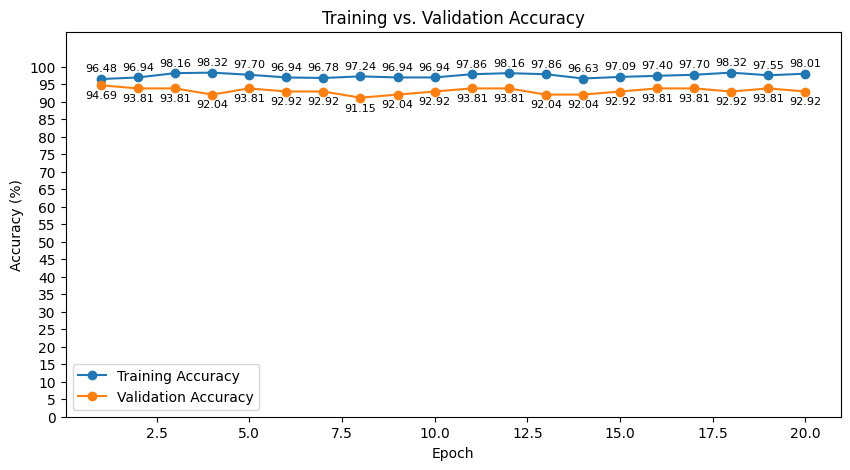

Accuracy plot saved as accuracy_plot.png


<Figure size 640x480 with 0 Axes>

In [51]:
# 5. Plotting the results
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
for i, (x, y) in enumerate(zip(range(1, num_epochs + 1), train_accuracies)):
    plt.text(x, y + 1.5, f'{y:.2f}', ha='center', va='bottom', fontsize=8)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
for i, (x, y) in enumerate(zip(range(1, num_epochs + 1), val_accuracies)):
    plt.text(x, y - 1.5, f'{y:.2f}', ha='center', va='top', fontsize=8)
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
# Set y-axis ticks to be at a gap of 5
plt.yticks(np.arange(0, 101, 5))
plt.ylim(0, 110)
plt.legend()
plt.show()
plt.savefig('accuracy_plot.png')
print("Accuracy plot saved as accuracy_plot.png")

In [53]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Waste Segregation /resnet50_waste_model.pth')
print("Model saved as resnet50_waste_model.pth")

Model saved as resnet50_waste_model.pth
